2198 751
Proportion of train_set : 0.75%
Proportion of valid_set : 0.25%


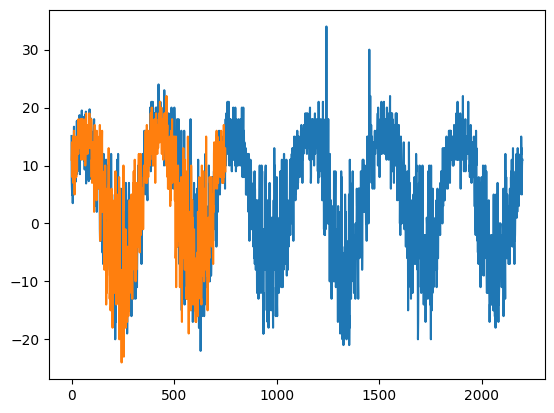

In [46]:
from experiment import Experiment
from utils.plot import plot_predictions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


solar_power = pd.read_csv('./data/solarpanelspower/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'date'}).set_index('date')
def generate_data(num_steps: int, interval: float = 0.1) -> None:
    x = np.linspace(0, num_steps * interval, num_steps)
    y = np.sin(x) + np.random.normal(0, 0.1, x.shape)
    return y


# solar_power['Elec_kW'] =generate_data(len(solar_power))


split_date = '2017-10-31'
train_set = solar_power[:split_date]
valid_set = solar_power[split_date:]
print(len(train_set), len(valid_set))
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))
# print('Proportion of test_set : {:.2f}%'.format(len(test_set)/len(solar_power)))
plt.plot(train_set.Elec_kW.values);plt.plot(valid_set.Elec_kW.values)

---
#### DecoderOnly

In [47]:
import math
import time
from torch.utils.data import DataLoader
from torch import nn
import torch


class DecoderOnly(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, 
        num_layers, dim_feedforward, block_size
    ) -> None:
        """Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()
        self.train_loss_history = []
        self.validation_loss_history = []
        self.block_size = block_size
        #
        # self.positional_encoding = PositionalEncoding(embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=block_size, embedding_dim=embed_dim)

        self.encoder_embedding = torch.nn.Linear(in_features=in_dim, out_features=embed_dim)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim, out_features=embed_dim)
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)


        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=embed_dim, 
                nhead=num_heads, 
                dim_feedforward=dim_feedforward, 
                dropout=0.1, batch_first=True, device='cuda'), 
        num_layers, norm=None)
    def is_transformer(self, ): return True

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        B, T, C = src.shape
        # if self.train:# Add noise to decoder inputs during training
        #     tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)
        # Embed encoder input and add positional encoding [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = src +  self.pos_emb(torch.arange(src.shape[1]).to('cuda'))# (B, T) --> (B, T, Emb) = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.[tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding. [bs, tgt_seq_len, embed_dim]
        # Get prediction from transformer and map to output dimension.[bs, tgt_seq_len, embed_dim]
        pred = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=None)
        pred = self.output_layer(pred)
        return pred
    
    @torch.no_grad()
    def validate(self, data):
        self.eval()
        val_loader = DataLoader(data, batch_size=1024, shuffle=False)
        loss_fn = nn.MSELoss()
        val_loss = 0.0
        #
        with torch.no_grad():
            for enc_x, dec_x, tgt_y in val_loader:
                pred_y = self(enc_x, dec_x)
                val_loss += loss_fn(pred_y, tgt_y)
        val_loss = val_loss/len(val_loader)
        self.train()
        return val_loss
    
    # @torch.no_grad()
    # def predict(self, src, forecast_horizon):
    #     self.eval()
    #     # output = torch.zeros(1, forecast_horizon + 1, 1).to('cuda') # fh + 1 because of the startsequence value in decoder
    #     output = src[0, -1].view(1, 1, 1) # first value
    #     print(output.shape)
    #     output[0, 0, 0] = src[0, -1] 
    #     for i in range(forecast_horizon):
    #         y = self(src, output[-self.block_size:])[0,i,0]
    #         output[0,i+1,0] = y
    #     return output[:,1:,:] # remove first value (copy from last history step)
    @torch.no_grad()
    def predict(self, src, forecast_horizon):
        self.eval()
        src = src[:, -self.block_size:, :]
        output = src[0, -1].clone().view(1, 1, 1) # first value
        for i in range(forecast_horizon):
            y_next = self(src, output[:, -self.block_size:, :])
            y_next = y_next[:, -1:, :]
            # concatenate in each batch along the time dimension
            output = torch.concat((output, y_next), dim=1)
        return output[:, 1: ,: ] # remove first value (copy from last history step)

    def fit(self, conf):
        self.train()
        expected_vars = ['epochs','lr','batch_size','train_dataset','validate_freq']
        for v in expected_vars:
            assert v in conf.keys(), f'Key "{v}" is missing on params dict'
        #
        epochs = conf['epochs']
        verbose = conf['verbose']
        train_dataset = conf['train_dataset']
        val_dataset = conf.get('train_dataset',None)
        validate_freq = conf.get('validate_freq',10)
        #
        optimizer = torch.optim.Adam(self.parameters(), lr=conf['lr'])
        loss_fn = nn.MSELoss()
        train_loader = DataLoader(train_dataset, batch_size=conf['batch_size'], shuffle=True)
        for epoch_i in range(epochs):
            timr = time.time()
            epoch_loss = .0
            val_loss = -1
            for enc_x, dec_x, tgt_y in train_loader:
                optimizer.zero_grad() # current batch zero-out the loss
                pred_y = self(enc_x, dec_x)
                loss = loss_fn(pred_y, tgt_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss        
            # end epoch
            epoch_loss = epoch_loss/len(train_loader)
            self.train_loss_history.append(epoch_loss.to('cpu').detach().numpy())
            to_validate = (val_dataset is not None) and (epoch_i % validate_freq == 0)
            if verbose:
                if to_validate: 
                    val_loss = self.validate(val_dataset)
                    self.validation_loss_history.append(val_loss.to('cpu').detach().numpy())
                    timr = time.time() - timr
                    print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f} | Validation loss: {val_loss:.5f}')
                else: 
                    timr = time.time() - timr
                    print(f'Epoch {epoch_i+1}/{epochs} [{timr:.3f}secs] -> Train loss: {epoch_loss:.5f}')
            
           

block_size = 256
fh = 256
model_params={
    'in_dim': 1, 
    'out_dim':1, 
    'embed_dim': 16, 
    'num_heads': 4, 
    'num_layers': 4,
    'dim_feedforward':128,
    'block_size':block_size
}
torch.cuda.empty_cache()
import gc
gc.collect()
model = TransformerWithPE(**model_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Num of weights:',pytorch_total_params)
# print(model)

NameError: name 'TransformerWithPE' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler
exp = Experiment(
    {
        # Model
        'model': model,
        'input_len':block_size,
        'feature_dim':1,
        'forecast_horizon':fh,
        # Data
        'frequency':'daily',
        'scaler': MinMaxScaler((-1,1)),
        'decompose': False, #detrend and de-sazonalize
        'freq':1,
        # Others
        'device':'cuda',
        'verbose':True,
    })
#

exp.set_dataset(linear_serie=train_set.Elec_kW.values, train=True)
exp.set_dataset(linear_serie=valid_set.Elec_kW.values, validation=True)

#
exp.train({
    'epochs':512,
    'lr':1e-3,
    'batch_size':512,
    'validate_freq':1,
    'verbose':True,
})

Scaler FIT
Epoch 1/512 [4.001secs] -> Train loss: 0.20588 | Validation loss: 0.12926
Epoch 2/512 [3.677secs] -> Train loss: 0.15682 | Validation loss: 0.13298
Epoch 3/512 [3.718secs] -> Train loss: 0.14496 | Validation loss: 0.12509
Epoch 4/512 [3.722secs] -> Train loss: 0.14019 | Validation loss: 0.11878
Epoch 5/512 [3.698secs] -> Train loss: 0.13447 | Validation loss: 0.11917


In [ ]:
exp.train({
    'epochs':512,
    'lr':1e-3,
    'batch_size':512,
    'validate_freq':10,
    'verbose':True,
})

Epoch 1/512 [1.735secs] -> Train loss: 91.05776 | Validation loss: 88.92746
Epoch 2/512 [1.359secs] -> Train loss: 89.94550
Epoch 3/512 [1.360secs] -> Train loss: 88.81836
Epoch 4/512 [1.356secs] -> Train loss: 88.23607
Epoch 5/512 [1.369secs] -> Train loss: 87.07896
Epoch 6/512 [1.371secs] -> Train loss: 86.22639
Epoch 7/512 [1.362secs] -> Train loss: 84.72777
Epoch 8/512 [1.366secs] -> Train loss: 84.00148
Epoch 9/512 [1.360secs] -> Train loss: 83.34574
Epoch 10/512 [1.360secs] -> Train loss: 82.26234
Epoch 11/512 [1.748secs] -> Train loss: 81.24905 | Validation loss: 79.58646
Epoch 12/512 [1.356secs] -> Train loss: 80.39520
Epoch 13/512 [1.358secs] -> Train loss: 79.23959
Epoch 14/512 [1.362secs] -> Train loss: 78.27213
Epoch 15/512 [1.362secs] -> Train loss: 77.27082
Epoch 16/512 [1.363secs] -> Train loss: 76.04070
Epoch 17/512 [1.370secs] -> Train loss: 75.31345
Epoch 18/512 [1.374secs] -> Train loss: 74.17528
Epoch 19/512 [1.350secs] -> Train loss: 73.39859
Epoch 20/512 [1.374sec

KeyboardInterrupt: 

In [ ]:
fh = block_size
ts = train_set.Elec_kW.values[-block_size:]
ts_future = valid_set.Elec_kW.values[:fh*5]
#
ts = exp.preprocess(ts) # TODO add ts copy 
output = exp.model.predict(ts, fh)
# rescale and add trend, etc..
output = exp.posprocess(output)
    # # exp.print_metrics(next_validation_values[:fh], pred_y[:fh])
plot_predictions(train_set.Elec_kW.values[-block_size:], ts_future, output)
    

In [ ]:
def _predict(self, src, block_size, forecast_horizon):
        # src = src[:, 0:]
        # self.eval()
        fh = 128
        print(src.shape)
        # with torch.no_grad():
        #     output = torch.zeros(1, forecast_horizon + 1, 1).to('cuda')
        #     output[0, 0, 0] = src[0, -1] # first value
        #     for i in range(forecast_horizon):
        #         y = self(src, output)[0,i,0]
        #         output[0,i+1,0] = y
        # return output[:,1:,:] # remove first value (copy from last history step)
# exp.model.predict = lambda a, b, c: _predict(exp.model, a, b, c)

last_train_values = train_set.Elec_kW.values[-block_size:]
next_validation_values = valid_set.Elec_kW.values[:fh*5]
pred_y = exp.predict(last_train_values, fh*3)
# exp.print_metrics(next_validation_values[:fh], pred_y[:fh])
# plot_predictions(train_set.Elec_kW.values[-1000:], next_validation_values, pred_y)

TypeError: TransformerWithPE.predict() takes 3 positional arguments but 4 were given

In [ ]:
def _predict(self, src, input_len, forecast_horizon):
        self.eval()
        fh = 128
        with torch.no_grad():
            output = torch.zeros(1, forecast_horizon + 1, 1).to('cuda')
            output[0, 0, 0] = src[0, -1] # first value
            for i in range(forecast_horizon):
                y = self(src, output)[0,i,0]
                output[0,i+1,0] = y
            #
            src = torch.concat((src, output[:,1:,:]), axis=1)
            output2 = torch.zeros(1, forecast_horizon + 1, 1).to('cuda')
            output2[0, 0, 0] = src[0, -1] # first value
            for i in range(forecast_horizon):
                y = self(src, output2)[0,i,0]
                output2[0,i+1,0] = y
        
        ret = torch.concat((output[:,1:,:], output2[:,1:,:]), axis=1)
        print(ret.shape)
        
        return ret # remove first value (copy from last history step)
        # return output[:,1:,:] # remove first value (copy from last history step)
exp.model.predict = lambda a, b, c: _predict(exp.model, a, b, c)

last_train_values = train_set.Elec_kW.values[-input_len:]
next_validation_values = valid_set.Elec_kW.values[:fh+100]
pred_y = exp.predict(last_train_values, fh)
exp.print_metrics(next_validation_values[:fh], pred_y[:fh])
plot_predictions(train_set.Elec_kW.values[-900:], next_validation_values, pred_y)

torch.Size([1, 256, 1])
MSE: 12.7454 | MAPE: 0.3172 | sMAPE: 0.2227


In [ ]:
from utils.generators import generate_data

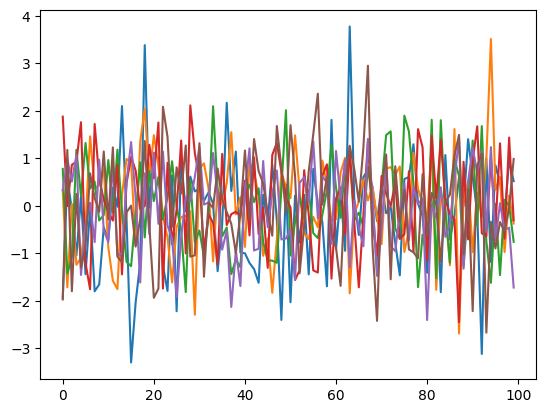

KeyboardInterrupt: 

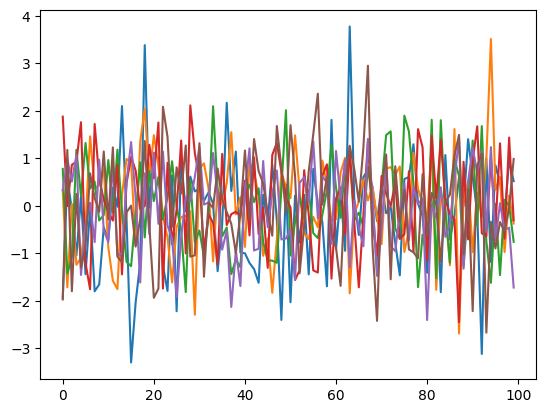

---